<font size="85">New Brunswick $27^\circ$ Gable Roof Building: Wind Tunnel Test</font> <br>
***
Feb 25, 2023

# Project description

The study building is a 27 degree gable roof building with ridge height 9.8 m, width 14 m, and length 41 m. It is situated in a suburban surrounding all around except the North end. The North is exposed to an open terrain from the airport except for a couple of houses immediately next to it. 

| Parameter | Value |
| --- | --- |
| Geometric scale | 1:100 |
| Velocity scale | TBD |
| Sampling period | 180s |
| Sampling frequency | 500Hz |
| Reference wind tunnel speed | 60fps |
| Number of exposures to be tested | Two exposures |
| Profile measurement | Not required |
| Tunnel setup | The tunnel configurations for the two exposures are given in Table 1 |
| Pressure taps | 440 taps (see Figure 3 for the layout) |
| Number of scanners required | 30 |
| Test angles, $\theta$ | 0° to 350° at 10°; 45°; 135°; 225°; and 315°. (40 directions) |
| Number of runs | 8 (2 field conditions of Case 1, 6 for the other cases) |
| Other instrumentation | None |
| Dummy models | The dummy models will be built from the dense foam typically used by BLWTL to model surrounding buildings. |
| Turntable setup | Several neighboring buildings and trees close to the study building will be crudely modeled for Case 1. |


**Case matrix**
| Case | Name | Surround | Exp-2 | Exp-4 |
| --- | --- | --- | --- | --- |
| 1 | fld | X | X | X |
| 2 | iso |  | X |  |
| 3 | xd |  | X |  |
| 4 | xdd |  | X |  |
| 5 | dxd |  | X |  |
| 6 | xddd |  | X |  |
| 7 | dxdd |  | X |  |



## Basic definitions

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import json

import windIO
import wind
import windCAD
import foam

### Files and directories

In [2]:
# Directories
rawHFPIdir = r""
workDir = r"D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/"
profileDir = workDir + r"Data/windTunnel/profiles/"
outputDir = workDir + r"Data/windTunnel/"
figDir = outputDir + r"__plots/"

# Files
tapFile = workDir + r"Drawings/nrcNBwtTapDefinition.csv"


### General parameters

In [3]:
saveFigs = False
caseNames = ['fld', 'iso', 'xd', 'xdd', 'dxd', 'xddd', 'dxdd']

### Scaling
The geometric length scale is decided based on the optimal fitting the model in the wind tunnel.
$$ \lambda_L=1:100 $$

The velocity scale is calculated by assuming the design wind speed according to NBCC 2020. The values for Moncton, NB (the nearest available location to Dieppe, NB), are:
$$ q_{1/50}=0.5 kPa $$
$$ U_{10}=\sqrt{\frac{2q}{\rho}}=27.8 m/s $$

Assuming an approximate roof height wind speed at the model scale to be $U_H^{WT}=10m/s$ (will be updated after the test) and considering the roof height ($H=8m/s$) close enough to $10m$:
$$ \lambda_V= \frac{U_H^{WT}}{U_{10}}=1:2.78 $$

Thus, the time scale is:
$$ \lambda_T = \frac{\lambda_L}{\lambda_V} = 1:36 $$

This means the model scale duration equivalent to the full-scale $1hr$ is $100s$.

## Building Geometry

### Basic geometry

| Dimension | Unit |
| --- | --- |
| Length | $mm$ |
| Time | $s$ |
| Velocity | $m/s$ |
| Density | $kg/m^3$ |

In [4]:
H = 80*wind.mm2m  # average roof height
Hr = 97.5*wind.mm2m  # ridge height
He = 62.5*wind.mm2m  # eaves height
Havg = np.mean([Hr, He])
B = 410*wind.mm2m
D = 138.7*wind.mm2m
alpha = 26.1  # roof slope

lScl=1/100.0
vScl=1/2.78
tScl=lScl

badTaps = {
    caseNames[0]: [],
    caseNames[1]: [],
    caseNames[2]: [],
    caseNames[3]: [],
    caseNames[4]: [],
    caseNames[5]: [],
    caseNames[6]: [],
}

print(Havg)

0.08


### Basics of faces

In [5]:

tapData = pd.read_csv(tapFile, na_filter=False)

faceID = [1,2,3,4,5,6]
name = ['West_roof','East_roof','East_wall','North_wall','West_wall','South_wall']
note = ['','','','','','']
origin = [[0, -71.6, 62.5], [0, 71.6, 62.5], [0, 69.35, 0], [-205, 0, 0], [0, -69.35, 0], [205, 0, 0], ]

basisVectors = [
            [[1, 0, 0], [0, 0.898027575760616, 0.439939169855915], [0, -0.439939169855915, 0.898027575760616]], 
            [[-1, 0, 0], [0, -0.898027575760616, 0.439939169855915], [0, 0.439939169855915, 0.898027575760616]], 
            [[-1, 0, 0], [0, 0, 1], [0, 1, 0]], 
            [[0, -1, 0], [0, 0, 1], [-1, 0, 0]], 
            [[1, 0, 0], [0, 0, 1], [0, -1, 0]], 
            [[0, 1, 0], [0, 0, 1], [1, 0, 0]], 
            ]

# origin_plt = [[0, 79.6967], [0, -79.6967], [0, -223.5182], [-357.0189, 0], [0, -223.5182], [357.0189, 0], ]
origin_plt = [[0, -79.6967], [0, -79.6967], [0, -150], [0, -320], [0, -150], [0, -320], ]

basisVectors_plt = [
            [[1, 0], [0, 1]],       # Face 1 (West_roof)
            [[-1, 0], [0, -1]],     # Face 2 (East_roof)
            [[-1, 0], [0, -1]],     # Face 3 (East_wall)
            [[0, 1], [-1, 0]],      # Face 4 (North_wall)
            [[1, 0], [0, 1]],       # Face 5 (West_wall)
            [[0, -1], [1, 0]],      # Face 6 (South_wall)
            ]

vertices_basic = [
            [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [-207.25, 0], ],  # Face 1
            [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [-207.25, 0], ],  # Face 2
            [[-205, 0], [-205, 60.76], [205, 60.76], [205, 0], [-205, 0], ],  # Face 3
            [[-69.35, 0], [-69.35, 61.8599], [0, 95.76], [69.35, 61.8599], [69.35, 0], [-69.35, 0], ],  # Face 4
            [[-205, 0], [-205, 60.76], [205, 60.76], [205, 0], [-205, 0], ],  # Face 5
            [[-69.35, 0], [-69.35, 61.8599], [0, 95.76], [69.35, 61.8599], [69.35, 0], [-69.35, 0], ],  # Face 6
            ]

vertices_full = [
            [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [-207.25, 0], ],  # Face 1
            [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [72.4, 0], [51.85, 24.6713], [31.3, 0], [-55.6, 0], [-83.05, 24.6713], [-110.5, 0], [-207.25, 0], ],  # Face 2
            [[-205, 0], [-205, 60.76], [205, 60.76], [205, 0], [-205, 0], ],  # Face 3
            [[-69.35, 0], [-69.35, 61.8599], [0, 95.76], [69.35, 61.8599], [69.35, 69.35], [-69.35, 0], ],  # Face 4
            [],  # Not sure what to do with this yet because it's broken into 3 parts
            [[-69.35, 0], [-69.35, 61.8599], [0, 95.76], [69.35, 61.8599], [69.35, 69.35], [-69.35, 0], ],  # Face 6
            ]

### Zone dictionary

In [6]:
zoneDict_basic = [
        {   # Face 1
            0:['NBCC 2020', 'Zone c', np.array([[193.38, 0, ], [193.38, 13.87, ], [207.25, 13.87, ], [207.25, 0, ], [193.38, 0, ], ])],
            1:['NBCC 2020', 'Zone c', np.array([[193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], ])],
            2:['NBCC 2020', 'Zone c', np.array([[-193.38, 0, ], [-193.38, 13.87, ], [-207.25, 13.87, ], [-207.25, 0, ], [-193.38, 0, ], ])],
            3:['NBCC 2020', 'Zone c', np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], ])],
            4:['NBCC 2020', 'Zone sp', np.array([[179.51, 65.8267, ], [179.51, 79.6967, ], [193.38, 79.6967, ], [193.38, 65.8267, ], [179.51, 65.8267, ], ])],
            5:['NBCC 2020', 'Zone sp', np.array([[193.38, 13.87, ], [193.38, 65.8267, ], [207.25, 65.8267, ], [207.25, 13.87, ], [193.38, 13.87, ], ])],
            6:['NBCC 2020', 'Zone sp', np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [-193.38, 79.6967, ], [-193.38, 65.8267, ], [-179.51, 65.8267, ], ])],
            7:['NBCC 2020', 'Zone sp', np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [-207.25, 65.8267, ], [-207.25, 13.87, ], [-193.38, 13.87, ], ])],
            8:['NBCC 2020', 'Zone s', np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [179.51, 79.6967, ], [179.51, 65.8267, ], [-179.51, 65.8267, ], ])],
            9:['NBCC 2020', 'Zone s', np.array([[-193.38, 0, ], [-193.38, 13.87, ], [193.38, 13.87, ], [193.38, 0, ], [-193.38, 0, ], ])],
           10:['NBCC 2020', 'Zone r', np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 13.87, ], [-193.38, 13.87, ], ])],
        #    11:['ASCE 7-22', 'Zone 3', np.array([[-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], ])],
        #    12:['ASCE 7-22', 'Zone 3', np.array([[207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], ])],
        #    13:['ASCE 7-22', 'Zone 2', np.array([[-207.25, 65.8267, ], [-207.25, 0, ], [-193.38, 0, ], [-193.38, 65.8267, ], [-207.25, 65.8267, ], ])],
        #    14:['ASCE 7-22', 'Zone 2', np.array([[207.25, 65.8267, ], [207.25, 0, ], [193.38, 0, ], [193.38, 65.8267, ], [207.25, 65.8267, ], ])],
        #    15:['ASCE 7-22', 'Zone 2', np.array([[-193.38, 79.6967, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 79.6967, ], [-193.38, 79.6967, ], ])],
        #    16:['ASCE 7-22', 'Zone 1', np.array([[-193.38, 65.8267, ], [-193.38, 0, ], [193.38, 0, ], [193.38, 65.8267, ], [-193.38, 65.8267, ], ])],
        },
        {   # Face 2
            0:['NBCC 2020', 'Zone c', np.array([[193.38, 0, ], [193.38, 13.87, ], [207.25, 13.87, ], [207.25, 0, ], [193.38, 0, ], ])],
            1:['NBCC 2020', 'Zone c', np.array([[193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], ])],
            2:['NBCC 2020', 'Zone c', np.array([[-193.38, 0, ], [-193.38, 13.87, ], [-207.25, 13.87, ], [-207.25, 0, ], [-193.38, 0, ], ])],
            3:['NBCC 2020', 'Zone c', np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], ])],
            4:['NBCC 2020', 'Zone sp', np.array([[179.51, 65.8267, ], [179.51, 79.6967, ], [193.38, 79.6967, ], [193.38, 65.8267, ], [179.51, 65.8267, ], ])],
            5:['NBCC 2020', 'Zone sp', np.array([[193.38, 13.87, ], [193.38, 65.8267, ], [207.25, 65.8267, ], [207.25, 13.87, ], [193.38, 13.87, ], ])],
            6:['NBCC 2020', 'Zone sp', np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [-193.38, 79.6967, ], [-193.38, 65.8267, ], [-179.51, 65.8267, ], ])],
            7:['NBCC 2020', 'Zone sp', np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [-207.25, 65.8267, ], [-207.25, 13.87, ], [-193.38, 13.87, ], ])],
            8:['NBCC 2020', 'Zone s', np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [179.51, 79.6967, ], [179.51, 65.8267, ], [-179.51, 65.8267, ], ])],
            9:['NBCC 2020', 'Zone s', np.array([[-193.38, 0, ], [-193.38, 13.87, ], [193.38, 13.87, ], [193.38, 0, ], [-193.38, 0, ], ])],
           10:['NBCC 2020', 'Zone r', np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 13.87, ], [-193.38, 13.87, ], ])],
        #    11:['ASCE 7-22', 'Zone 3', np.array([[-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], ])],
        #    12:['ASCE 7-22', 'Zone 3', np.array([[207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], ])],
        #    13:['ASCE 7-22', 'Zone 2', np.array([[-207.25, 65.8267, ], [-207.25, 0, ], [-193.38, 0, ], [-193.38, 65.8267, ], [-207.25, 65.8267, ], ])],
        #    14:['ASCE 7-22', 'Zone 2', np.array([[207.25, 65.8267, ], [207.25, 0, ], [193.38, 0, ], [193.38, 65.8267, ], [207.25, 65.8267, ], ])],
        #    15:['ASCE 7-22', 'Zone 2', np.array([[-193.38, 79.6967, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 79.6967, ], [-193.38, 79.6967, ], ])],
        #    16:['ASCE 7-22', 'Zone 1', np.array([[-193.38, 65.8267, ], [-193.38, 0, ], [193.38, 0, ], [193.38, 65.8267, ], [-193.38, 65.8267, ], ])],
        },
        {   # Face 3
            0:['NBCC 2020', 'Zone e', np.array([[191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], [205, 0, ], [191.13, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [191.13, 60.76, ], [191.13, 0, ], [-191.13, 0, ], ])],
            # 3:['ASCE 7-22', 'Zone 5', np.array([[-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], ])],
            # 4:['ASCE 7-22', 'Zone 5', np.array([[205, 60.76, ], [205, 0, ], [191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], ])],
            # 5:['ASCE 7-22', 'Zone 4', np.array([[-191.13, 60.76, ], [-191.13, 0, ], [191.13, 0, ], [191.13, 60.76, ], [-191.13, 60.76, ], ])],
        },
        {   # Face 4
            0:['NBCC 2020', 'Zone e', np.array([[-69.35, 0, ], [-69.35, 61.8599, ], [-55.48, 68.6399, ], [-55.48, 0, ], [-69.35, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[69.35, 0, ], [69.35, 61.8599, ], [55.48, 68.6399, ], [55.48, 0, ], [69.35, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-55.48, 0, ], [-55.48, 68.6399, ], [0, 95.76, ], [55.48, 68.6399, ], [55.48, 0, ], [-55.48, 0, ], ])],
            # 3:['ASCE 7-22', 'Zone 5', np.array([[-69.35, 61.8599, ], [-69.35, 0, ], [-55.48, 0, ], [-55.48, 68.6399, ], [-69.35, 61.8599, ], ])],
            # 4:['ASCE 7-22', 'Zone 5', np.array([[69.35, 61.8599, ], [69.35, 0, ], [55.48, 0, ], [55.48, 68.6399, ], [69.35, 61.8599, ], ])],
            # 5:['ASCE 7-22', 'Zone 4', np.array([[-55.48, 68.6399, ], [-55.48, 0, ], [55.48, 0, ], [55.48, 68.6399, ], [0, 95.76, ], [-55.48, 68.6399, ], ])],
        },
        {   # Face 5
            0:['NBCC 2020', 'Zone e', np.array([[191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], [205, 0, ], [191.13, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [191.13, 60.76, ], [191.13, 0, ], [-191.13, 0, ], ])],
            # 3:['ASCE 7-22', 'Zone 5', np.array([[-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], ])],
            # 4:['ASCE 7-22', 'Zone 5', np.array([[205, 60.76, ], [205, 0, ], [191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], ])],
            # 5:['ASCE 7-22', 'Zone 4', np.array([[-191.13, 60.76, ], [-191.13, 0, ], [191.13, 0, ], [191.13, 60.76, ], [-191.13, 60.76, ], ])],
        },
        {   # Face 6
            0:['NBCC 2020', 'Zone e', np.array([[-69.35, 0, ], [-69.35, 61.8599, ], [-55.48, 68.6399, ], [-55.48, 0, ], [-69.35, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[69.35, 0, ], [69.35, 61.8599, ], [55.48, 68.6399, ], [55.48, 0, ], [69.35, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-55.48, 0, ], [-55.48, 68.6399, ], [0, 95.76, ], [55.48, 68.6399, ], [55.48, 0, ], [-55.48, 0, ], ])],
            # 3:['ASCE 7-22', 'Zone 5', np.array([[-69.35, 61.8599, ], [-69.35, 0, ], [-55.48, 0, ], [-55.48, 68.6399, ], [-69.35, 61.8599, ], ])],
            # 4:['ASCE 7-22', 'Zone 5', np.array([[69.35, 61.8599, ], [69.35, 0, ], [55.48, 0, ], [55.48, 68.6399, ], [69.35, 61.8599, ], ])],
            # 5:['ASCE 7-22', 'Zone 4', np.array([[-55.48, 68.6399, ], [-55.48, 0, ], [55.48, 0, ], [55.48, 68.6399, ], [0, 95.76, ], [-55.48, 68.6399, ], ])],
        },
]


### Face objects

In [7]:
faces = []
for i,f in enumerate(faceID):
    idx = tapData.index[tapData.faceID == f]
    tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
    tapNos = np.array(tapData.tapNo[idx],dtype=int)
    tapName = tapData.tapName[idx]
    idxOrig = idx

    fc = windCAD.face(
                name=name[i],
                ID=f,
                origin=origin[i],
                basisVectors=basisVectors[i],
                origin_plt=origin_plt[i],
                basisVectors_plt=basisVectors_plt[i],
                vertices=vertices_basic[i],
                tapNo=tapNos,
                tapIdx=idxOrig,
                tapName=tapName,
                tapCoord=tapCoords,
                zoneDict=zoneDict_basic[i],
                # nominalPanelAreas=[4.4e-5, 8.15e-5, 1.3e-4, 5e-4, 6.8e-4, 1.3e-3,],   # Final! All are tested. 1.3e-3 results in blunt edge zones in the walls but no error.
                nominalPanelAreas=[50.0, 200.0, 470, 785], 
                badTaps=badTaps,
                allBldgTaps=np.array(tapData.tapNo, dtype=int),
                )
    # fc.plot(figSize=[20,15], overlayPanels=True, overlayTaps=True, overlayTribs=True, overlayZones=True)
    faces.append(fc)

# file = caseDir+'ttu_bldgGeom.json'
# allFaces.writeToFile(file_basic=file)

Generating panels ...


d:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:474: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  print(f"Shape of 'panels': {np.shape(np.array(self.panels,dtype=object))}")
d:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:474: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  print(f"Shape of 'panels': {np.shape(np.array(self.panels,dtype=object))}")


Shape of 'panels': (11, 4)
Shape of 'panelAreas': (11, 4)
Shape of 'pnlWeights': (11, 4)
Shape of 'tapIdxByPnl': (11, 4)
Indecies of nominalPanelArea per each zone with error of unequal area between total sum of panel areas vs. zone: 
			((), (), (), (), (), (), (), (), (), (), ())
Indecies of panels within nominalPanelArea within zone with tap weights that do not sum to 1 : 
			(([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []))
Generating panels ...


d:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:474: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  print(f"Shape of 'panels': {np.shape(np.array(self.panels,dtype=object))}")
d:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:474: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  print(f"Shape of 'panels': {np.shape(np.array(self.panels,dtype=object))}")


Shape of 'panels': (11, 4)
Shape of 'panelAreas': (11, 4)
Shape of 'pnlWeights': (11, 4)
Shape of 'tapIdxByPnl': (11, 4)
Indecies of nominalPanelArea per each zone with error of unequal area between total sum of panel areas vs. zone: 
			((), (), (), (), (), (), (), (), (), (), ())
Indecies of panels within nominalPanelArea within zone with tap weights that do not sum to 1 : 
			(([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []))
Generating panels ...


d:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:455: UserWarning: The difference between Zone area and the sum of its panel areas exceeds the tolerance level.
  warnings.warn(f"The difference between Zone area and the sum of its panel areas exceeds the tolerance level.")
d:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:474: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  print(f"Shape of 'panels': {np.shape(np.array(self.panels,dtype=object))}")
d:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:474: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

Shape of 'panels': (3, 4)
Shape of 'panelAreas': (3, 4)
Shape of 'pnlWeights': (3, 4)
Shape of 'tapIdxByPnl': (3, 4)
Indecies of nominalPanelArea per each zone with error of unequal area between total sum of panel areas vs. zone: 
			((), (), (3,))
Indecies of panels within nominalPanelArea within zone with tap weights that do not sum to 1 : 
			(([], [], [], []), ([], [], [], []), ([], [], [], []))
Generating panels ...


d:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:455: UserWarning: The difference between Zone area and the sum of its panel areas exceeds the tolerance level.
  warnings.warn(f"The difference between Zone area and the sum of its panel areas exceeds the tolerance level.")
d:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:474: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  print(f"Shape of 'panels': {np.shape(np.array(self.panels,dtype=object))}")
d:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:474: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

Shape of 'panels': (3, 4)
Shape of 'panelAreas': (3, 4)
Shape of 'pnlWeights': (3, 4)
Shape of 'tapIdxByPnl': (3, 4)
Indecies of nominalPanelArea per each zone with error of unequal area between total sum of panel areas vs. zone: 
			((), (), (1,))
Indecies of panels within nominalPanelArea within zone with tap weights that do not sum to 1 : 
			(([], [], [], []), ([], [], [], []), ([], [], [], []))
Generating panels ...


d:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:455: UserWarning: The difference between Zone area and the sum of its panel areas exceeds the tolerance level.
  warnings.warn(f"The difference between Zone area and the sum of its panel areas exceeds the tolerance level.")
d:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:474: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  print(f"Shape of 'panels': {np.shape(np.array(self.panels,dtype=object))}")
d:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:474: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

Shape of 'panels': (3, 4)
Shape of 'panelAreas': (3, 4)
Shape of 'pnlWeights': (3, 4)
Shape of 'tapIdxByPnl': (3, 4)
Indecies of nominalPanelArea per each zone with error of unequal area between total sum of panel areas vs. zone: 
			((), (), (3,))
Indecies of panels within nominalPanelArea within zone with tap weights that do not sum to 1 : 
			(([], [], [], []), ([], [], [], []), ([], [], [], []))
Generating panels ...
Shape of 'panels': (3, 4)
Shape of 'panelAreas': (3, 4)
Shape of 'pnlWeights': (3, 4)
Shape of 'tapIdxByPnl': (3, 4)
Indecies of nominalPanelArea per each zone with error of unequal area between total sum of panel areas vs. zone: 
			((), (), (1,))
Indecies of panels within nominalPanelArea within zone with tap weights that do not sum to 1 : 
			(([], [], [], []), ([], [], [], []), ([], [], [], []))


d:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:455: UserWarning: The difference between Zone area and the sum of its panel areas exceeds the tolerance level.
  warnings.warn(f"The difference between Zone area and the sum of its panel areas exceeds the tolerance level.")
d:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:474: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  print(f"Shape of 'panels': {np.shape(np.array(self.panels,dtype=object))}")
d:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:474: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

### Building objects

In [8]:
bldg_iso = wind.bldgCp(bldgName='NRC-NB_1to100_UWO',
                faces=faces,
                H=H,D=D,B=B,roofSlope=alpha,lScl=lScl,
                caseName='Basic_No_Portico',
                badTaps=badTaps,
                )
print(bldg_iso.error_in_panels)
print(bldg_iso.error_in_zones)

[(([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], [])), (([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], [])), (([], [], [], []), ([], [], [], []), ([], [], [], [])), (([], [], [], []), ([], [], [], []), ([], [], [], [])), (([], [], [], []), ([], [], [], []), ([], [], [], [])), (([], [], [], []), ([], [], [], []), ([], [], [], []))]
[((), (), (), (), (), (), (), (), (), (), ()), ((), (), (), (), (), (), (), (), (), (), ()), ((), (), (3,)), ((), (), (1,)), ((), (), (3,)), ((), (), (1,))]


### Geometry plots

(-352.0, 352.0, -165.0, 165.0)

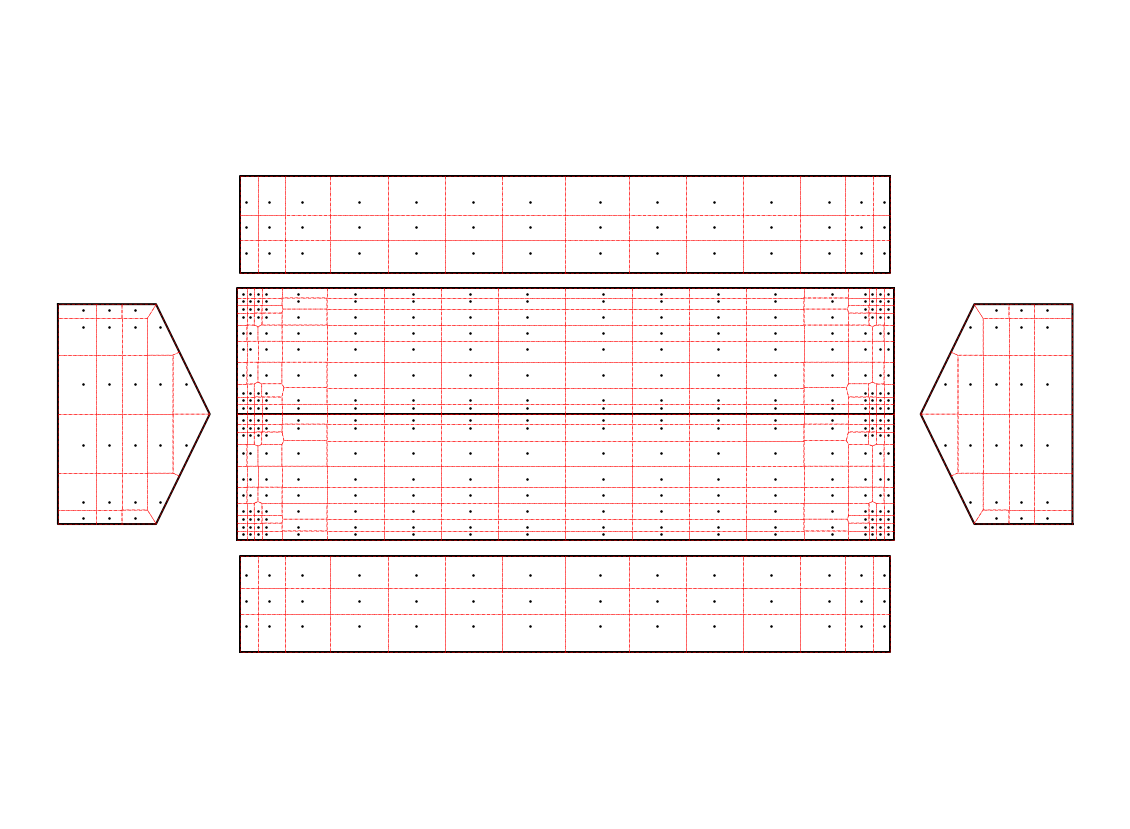

In [9]:
fig = plt.figure(figsize=[20,15])
ax = fig.add_subplot()

bldg_iso.plotEdges(ax=ax,showName=False)
bldg_iso.plotTaps(ax=ax,showTapNo=False)
# bldg_iso.plotZones(ax=ax)

bldg_iso.plotTribs(ax=ax)
# bldg_iso.plotPanels(ax=ax,aIdx=2)

ax.axis('equal')
ax.axis('off')
# if saveFigs:
    # fig.savefig(figDir+"tapLayout.svg",format='svg',dpi=1200, bbox_inches='tight')



## Wind field

### Exposure conditions

Tunnel configurations for the considered exposures

### Read data

In [10]:
sFreq = 1600
dt = 1/sFreq

pDir =profileDir+"tngE2/"
Z = pd.read_csv(pDir+"Z.csv").to_numpy()
U_TH = np.load(pDir+"UofT.npy")
V_TH = np.load(pDir+"VofT.npy")
W_TH = np.load(pDir+"WofT.npy")
vel_OP1 = wind.profile(name="BLWT (Open)", Z=Z,UofT=U_TH,VofT=V_TH,WofT=W_TH,H=H,dt=dt,nSpectAvg=32)

pDir =profileDir+"tngE3/"
Z = pd.read_csv(pDir+"Z.csv").to_numpy()
U_TH = np.load(pDir+"UofT.npy")
V_TH = np.load(pDir+"VofT.npy")
W_TH = np.load(pDir+"WofT.npy")
vel_OP2 = wind.profile(name="BLWT (Suburban)", Z=Z,UofT=U_TH.transpose(),VofT=V_TH.transpose(),WofT=W_TH.transpose(),H=H,dt=dt,nSpectAvg=32)

del(U_TH, V_TH, W_TH)

In [15]:
# esdu_OP = wind.ESDU74(z0=0.02, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))
esdu_OP = wind.ESDU85(z0=0.02, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))

# esdu_SU = wind.ESDU74(z0=0.2, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))
esdu_SU = wind.ESDU85(z0=0.2, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))

vel = wind.Profiles([vel_OP1, esdu_OP.toProfileObj(), vel_OP2, esdu_SU.toProfileObj()])

### Plot wind field

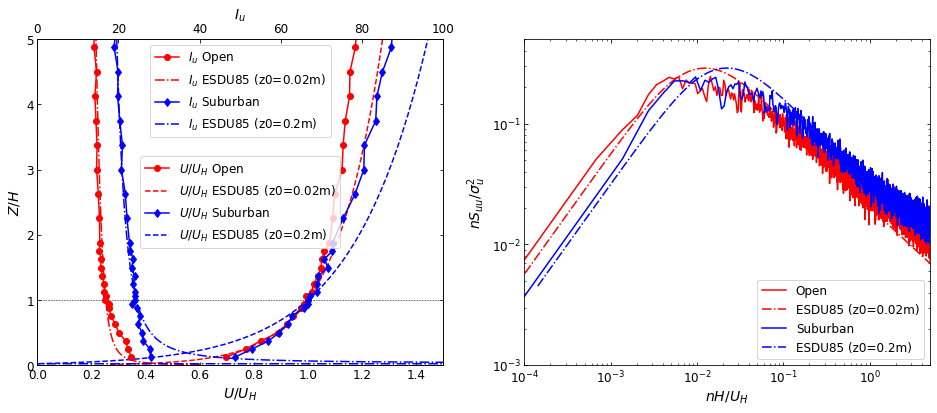

In [18]:
vel.plot(fig=plt.figure(figsize=[16,6]),zLim=[0,5], IuLim=[0,100], Ulim=[0,1.5],
        col=['r','r','b','b','g','g'],
        marker_Iu=   ['o','None','d','None','v','None'],
        linestyle_Iu=['-','-.',  '-','-.',  '-','--'],
        marker_U=    ['o','None','d','None','v','None'],
        linestyle_U= ['-','--',  '-','--',  '-','--'],
        marker_Spect=   ['None','None','None','None','None','None'],
        linestyle_Spect=['-','-.',  '-','-.',  '-','--'],
        IuLgndLoc='upper center', UlgndLoc='center',
        fontSz_axLbl=14, fontSz_axNum=12, fontSz_lgnd=12,
        freqLim=[1e-4, 5], rSuuLim=[1e-3,0.5]
        )

## Surface pressure, $C_p$

### Read data

In [ ]:
peakMethod = 'minmax'
Uh_FS = 25.0

#### Wind tunnel data

In [ ]:
mainRefPitotChnlIdx = 2

Zpitot = 1.48
Ntaps = 456
tMax = 12000  # approximately keeping the same duration
AoAids = ['001', '010', '019']

In [ ]:
N_AoA = len(AoAids)
AoA = np.zeros((N_AoA))
sampleRate = np.zeros((N_AoA))

for d,aoa in enumerate(AoAids):
    file_pssd = dir_wtCp_tngE2+'TNGp1E02R001P'+ AoAids[d] +'a.pssd'
    file_pssr = dir_wtCp_tngE2+'TNGp1E02R001P'+ AoAids[d] +'a.pssr'

    cp_data,analog,WTTDATALOG = windIO.readPSSfile(file_pssr,file_pssd)

    if d == 0:
        N_t = np.shape(cp_data)[0]
        CpTH = np.zeros((N_AoA,Ntaps,N_t)) # [N_AoA,Ntaps,Ntime]
        UpitotOfT = np.zeros((N_AoA,N_t))
    CpTH[d,:,:] = np.transpose(cp_data[:,0:Ntaps])
    UpitotOfT[d,:] = 29.917 * np.sqrt(analog[:,mainRefPitotChnlIdx]) * fps2mps
    AoA[d] = np.round(WTTDATALOG["APPSPE"][0][0][0][0][0][0][0][16][0][0],1)
    sampleRate[d] = WTTDATALOG["APPSPE"][0][0][0][0][0][0][0][12][0][0]
Upitot = np.mean(UpitotOfT,axis=1)

wtCp_tngE2 = wind.bldgCp(bldgName='TTU_1:50_TNG',
                faces=faces,
                H=H,D=D,B=B,roofSlope=1.2,lScl=lScl,
                caseName='tngE2p1',
                refProfile=wtVel_E2,
                Zref_input=Zpitot,
                Uref_input=Upitot,
                samplingFreq=sampleRate[0],
                AoA=AoA,
                CpOfT=CpTH[:,:,:tMax],
                badTaps=badTaps,
                reReferenceCpToH=True,
                pOfT=None,
                p0ofT=None,
                CpStats=None,
                peakMethod=peakMethod,
                keepTH=False,
                )
CpTH = analog = cp_data = None

In [ ]:
N_AoA = len(AoAids)
AoA = np.zeros((N_AoA))
sampleRate = np.zeros((N_AoA))

for d,aoa in enumerate(AoAids):
    file_pssd = dir_wtCp_tngE3+'TNGp1E03R001P'+ AoAids[d] +'a.pssd'
    file_pssr = dir_wtCp_tngE3+'TNGp1E03R001P'+ AoAids[d] +'a.pssr'

    cp_data,analog,WTTDATALOG = windIO.readPSSfile(file_pssr,file_pssd)

    if d == 0:
        N_t = np.shape(cp_data)[0]
        CpTH = np.zeros((N_AoA,Ntaps,N_t)) # [N_AoA,Ntaps,Ntime]
        UpitotOfT = np.zeros((N_AoA,N_t))
    CpTH[d,:,:] = np.transpose(cp_data[:,0:Ntaps])
    UpitotOfT[d,:] = 29.917 * np.sqrt(analog[:,mainRefPitotChnlIdx]) * fps2mps
    AoA[d] = np.round(WTTDATALOG["APPSPE"][0][0][0][0][0][0][0][16][0][0],1)
    sampleRate[d] = WTTDATALOG["APPSPE"][0][0][0][0][0][0][0][12][0][0]
Upitot = np.mean(UpitotOfT,axis=1)

wtCp_tngE3 = wind.bldgCp(bldgName='TTU_1:50_TNG',
                faces=faces,
                H=H,D=D,B=B,roofSlope=1.2,lScl=lScl,
                caseName='tngE3p1',
                refProfile=wtVel_E3,
                Zref_input=Zpitot,
                Uref_input=Upitot,
                samplingFreq=sampleRate[0],
                AoA=AoA,
                CpOfT=CpTH[:,:,:tMax],
                badTaps=badTaps,
                reReferenceCpToH=True,
                pOfT=None,
                p0ofT=None,
                CpStats=None,
                peakMethod=peakMethod,
                keepTH=False,
                )
CpTH = analog = cp_data = None

In [ ]:
print(bldg[1].NumTaps)
print(np.shape(bldg[1].tapNo_all))
print(np.shape(bldg[1].tapNo))
print(np.shape(bldg[1].tapIdx))
print(np.shape(bldg[1].tapTribs.geoms))
print(np.shape(bldg[1].tapCoord))
print(np.shape(bldg[1].tapCoord3D))
print(np.shape(bldg[1].tapWghtPerPanel))

ftp = bldg[1].tapNo
tp = bldg.tapNo
idx = np.where(np.isin(tp, ftp))[0]
print(np.shape(idx))

In [ ]:
tapNo = bldg.tapNo
TapNoAll = bldg.tapNo_all
tapIdx = bldg.tapIdx
expectedIdx = range(len(bldg.tapNo))

tapNo_0 = bldg[0].tapNo
tapNoAll_0 = bldg[0].tapNo_all
tapIdx_0 = bldg[0].tapIdx

expectedIdx_0 = np.where(np.in1d(tapNo, tapNo_0))[0]

print(np.shape(tapNo))
print(np.shape(TapNoAll))
print(np.shape(tapIdx))

print(np.shape(tapNo_0))
print(np.shape(tapNoAll_0))
print(np.shape(tapIdx_0))


#### LES data

In [ ]:
p0_ProbeName='probes.V0'
p0Idx = 30

trimTimeSegs=[[0,1.0]]
AoA = [0.0,45.0,90.0]

In [ ]:
def getClosestIdx(Tp, Tp0, tol=0.004):
    idx = np.zeros_like(Tp,dtype=int)
    for i,tp in enumerate(Tp):
        idx[i] = np.argmin(np.abs(Tp0-tp))
        if abs(tp-Tp0[idx[i]]) > tol:
            print(f"Time gap b/n p and p0: {abs(tp-Tp0[idx[i]])}")

    return idx


In [ ]:
sIdx = 700
eIdx = 10300
nTime = eIdx-sIdx

# 0 deg
pOfTfile = dir_lesE2_00+'postProcessing/wallPressure_pOfT_TNGtaps.npy'
pOfT = np.load(pOfTfile)
m,n = np.shape(pOfT)
pOfT = np.reshape(pOfT,(1,m,n))
T_p = np.load(dir_lesE2_00+'postProcessing/wallPressure_times.npy')

_, T_p0, p0OfT = foam.readProbe(probeName=p0_ProbeName, postProcDir=dir_lesE2_00+'postProcessing/', field='p', shiftTimeToZero=False)
p0OfT = np.reshape(np.transpose(p0OfT)[p0Idx,:],(1,1,-1))
idx_p0 = getClosestIdx(T_p, T_p0)
p0OfT = p0OfT[:,:,idx_p0]

pOfT = np.subtract(pOfT,p0OfT)[:,:,sIdx:eIdx]


# 45 deg
pOfTfile = dir_lesE2_45+'postProcessing/wallPressure_pOfT_TNGtaps.npy'
pOfT_ = np.load(pOfTfile)
m,n = np.shape(pOfT_)
pOfT_ = np.reshape(pOfT_,(1,m,n))
T_p = np.load(dir_lesE2_45+'postProcessing/wallPressure_times.npy')

_, T_p0, p0OfT_ = foam.readProbe(probeName=p0_ProbeName, postProcDir=dir_lesE2_45+'postProcessing/', field='p', shiftTimeToZero=False)
p0OfT_ = np.reshape(np.transpose(p0OfT_)[p0Idx,:],(1,1,-1))
idx_p0 = getClosestIdx(T_p, T_p0)
p0OfT_ = p0OfT_[:,:,idx_p0]

pOfT_ = np.subtract(pOfT_,p0OfT_)
pOfT = np.concatenate((pOfT, pOfT_[:,:,sIdx:eIdx]), axis=0)


# 90 deg
pOfTfile = dir_lesE2_90+'postProcessing/wallPressure_pOfT_TNGtaps.npy'
pOfT_ = np.load(pOfTfile)
m,n = np.shape(pOfT_)
pOfT_ = np.reshape(pOfT_,(1,m,n))
T_p = np.load(dir_lesE2_90+'postProcessing/wallPressure_times.npy')

_, T_p0, p0OfT_ = foam.readProbe(probeName=p0_ProbeName, postProcDir=dir_lesE2_90+'postProcessing/', field='p', shiftTimeToZero=False)
p0OfT_ = np.reshape(np.transpose(p0OfT_)[p0Idx,:],(1,1,-1))
idx_p0 = getClosestIdx(T_p, T_p0)
p0OfT_ = p0OfT_[:,:,idx_p0]

pOfT_ = np.subtract(pOfT_,p0OfT_)
pOfT = np.concatenate((pOfT, pOfT_[:,:,sIdx:eIdx]), axis=0)


lesCp_E2 = wind.bldgCp(bldgName='TTU_1:50_TNG',
                faces=faces,
                H=H,D=D,B=B,roofSlope=1.2,lScl=lScl,
                caseName='LES-E2',
                refProfile=lesVel_E2,
                Zref_input=H,  # for the Cp TH being input below
                Uref_input=lesVel_E2.Uh,  # for the Cp TH being input below
                samplingFreq=lesVel_E2.samplingFreq,
                AoA=AoA,
                pOfT=pOfT,
                peakMethod=peakMethod,
                badTaps=badTaps,
                # keepTH=False,
                )
pOfT = pOfT_ = None

In [ ]:
sIdx = 200
eIdx = 9930
nTime = eIdx-sIdx

# 0 deg
pOfTfile = dir_lesE3_00+'postProcessing/wallPressure_pOfT_TNGtaps.npy'
pOfT = np.load(pOfTfile)
m,n = np.shape(pOfT)
pOfT = np.reshape(pOfT,(1,m,n))
T_p = np.load(dir_lesE3_00+'postProcessing/wallPressure_times.npy')

_, T_p0, p0OfT = foam.readProbe(probeName=p0_ProbeName, postProcDir=dir_lesE3_00+'postProcessing/', field='p', shiftTimeToZero=False)
p0OfT = np.reshape(np.transpose(p0OfT)[p0Idx,:],(1,1,-1))
idx_p0 = getClosestIdx(T_p, T_p0)
p0OfT = p0OfT[:,:,idx_p0]

p0OfT = p0OfT[:,:,:-1]
pOfT = np.subtract(pOfT,p0OfT)[:,:,sIdx:eIdx]



# 45 deg
pOfTfile = dir_lesE3_45+'postProcessing/wallPressure_pOfT_TNGtaps.npy'
pOfT_ = np.load(pOfTfile)
m,n = np.shape(pOfT_)
pOfT_ = np.reshape(pOfT_,(1,m,n))
T_p = np.load(dir_lesE3_45+'postProcessing/wallPressure_times.npy')

_, T_p0, p0OfT_ = foam.readProbe(probeName=p0_ProbeName, postProcDir=dir_lesE3_45+'postProcessing/', field='p', shiftTimeToZero=False)
p0OfT_ = np.reshape(np.transpose(p0OfT_)[p0Idx,:],(1,1,-1))
idx_p0 = getClosestIdx(T_p, T_p0)
p0OfT_ = p0OfT_[:,:,idx_p0]

pOfT_ = np.subtract(pOfT_,p0OfT_)
pOfT = np.concatenate((pOfT, pOfT_[:,:,sIdx:eIdx]), axis=0)



# 90 deg
pOfTfile = dir_lesE3_90+'postProcessing/wallPressure_pOfT_TNGtaps.npy'
pOfT_ = np.load(pOfTfile)
m,n = np.shape(pOfT_)
pOfT_ = np.reshape(pOfT_,(1,m,n))
T_p = np.load(dir_lesE3_90+'postProcessing/wallPressure_times.npy')

_, T_p0, p0OfT_ = foam.readProbe(probeName=p0_ProbeName, postProcDir=dir_lesE3_90+'postProcessing/', field='p', shiftTimeToZero=False)
p0OfT_ = np.reshape(np.transpose(p0OfT_)[p0Idx,:],(1,1,-1))
idx_p0 = getClosestIdx(T_p, T_p0)
p0OfT_ = p0OfT_[:,:,idx_p0]

pOfT_ = np.subtract(pOfT_,p0OfT_)
pOfT = np.concatenate((pOfT, pOfT_[:,:,sIdx:eIdx]), axis=0)

lesCp_E3 = wind.bldgCp(bldgName='TTU_1:50_TNG',
                faces=faces,
                H=H,D=D,B=B,roofSlope=1.2,lScl=lScl,
                caseName='LES-E3',
                refProfile=lesVel_E3,
                Zref_input=H,  # for the Cp TH being input below
                Uref_input=lesVel_E3.Uh,  # for the Cp TH being input below
                samplingFreq=lesVel_E3.samplingFreq,
                AoA=AoA,
                pOfT=pOfT,
                # p0ofT=p0OfT[:,:,100:nT],
                peakMethod=peakMethod,
                badTaps=badTaps,
                # keepTH=False,
                )
pOfT = pOfT_ = None



### $C_p$ Plots

In [ ]:
# d = 1
# tap = 409
# t = bldg.tapNo.index(tap)

# plt.figure(figsize=[20,5])
# plt.plot(lesCp_E2.CpOfT[d,t,:],label='LES')
# plt.plot(wtCp_tngE3.CpOfT[d,t,:],label='WT')
# # plt.xlim([8000,8600])
# plt.legend()
# plt.show()


#### Local pressure

In [ ]:
# lesCp_E2.plotTapCpStatsPerAoA(fldRange=[-8,2.3],xticks=np.round(lesCp_E2.AoA,0),pageNo_xy=(0.5,0.06),nCols=13, figsize=[25,20])
# wtCp_tngE2.plotTapCpStatsPerAoA(fldRange=[-8,2.3],xticks=np.round(wtCp_tngE2.AoA,0),pageNo_xy=(0.5,0.06),nCols=13, figsize=[25,20])

# lesCp_E2.plotTapCpStatsPerAoA(fldRange=[-8,2.3],xticks=np.round(lesCp_E2.AoA,0),pageNo_xy=(0.5,0.06),nCols=13, figsize=[25,20])
# wtCp_tngE2.plotTapCpStatsPerAoA(fldRange=[-8,2.3],xticks=np.round(wtCp_tngE2.AoA,0),pageNo_xy=(0.5,0.06),nCols=13, figsize=[25,20])

In [ ]:
nrow, ncol = 2, N_AoA

fld = 'mean'
fldRange=[-1.6,0.8]

fig, axs = plt.subplots(nrow, ncol)
fig.set_figheight(5*nrow)
fig.set_figwidth(6*ncol)
fig.subplots_adjust(wspace=0.0, hspace=0.0)

for d,D in enumerate(lesCp_E2.AoA):
    ax = axs[0,d]
    wtCp_tngE2.plotTapCpStatContour(fieldName=fld,dxnIdx=d,ax=ax,fldRange=fldRange)
    wtCp_tngE2.plotEdges(ax=ax,showName=False)
    wtCp_tngE2.plotTaps(ax=ax,dotSz=1)
    ax.axis('off')
    ax.axis('equal')
    ax.set_title(r'$\theta='+str(np.round(D,0))+r'^\circ$',fontsize=16)

    ax = axs[1,d]
    lesCp_E2.plotTapCpStatContour(fieldName=fld,dxnIdx=d,ax=ax,fldRange=fldRange)
    lesCp_E2.plotEdges(ax=ax,showName=False)
    lesCp_E2.plotTaps(ax=ax,dotSz=1)
    ax.axis('off')
    ax.axis('equal')

# if saveFigs:
#     fig.savefig(figDir+"Cp_"+fld+".svg",format='svg',dpi=1200, bbox_inches='tight')

In [ ]:

fig, ax = plt.subplots()
cmap = plt.get_cmap('RdBu')

plt.axis('off')
norm = plt.Normalize(*fldRange)

cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cb.ax.set_title(r"Mean $C_p$")
plt.show()
if saveFigs:
    fig.savefig(figDir+"Cp_"+fld+"_cmap.svg",format='svg',dpi=1200, bbox_inches='tight')


In [ ]:
badTaps = np.array([1316, 1807, 2609,],dtype=int)
badIdx = np.where(np.in1d(bldg.tapNo, badTaps))[0]
mask = np.ones_like(bldg.tapNo, dtype=bool)
mask[badIdx] = False

fld = 'mean'
err_E2_mean = np.array([0,0,0],dtype=float)
for d in range(3):
    LES = lesCp_E2.CpStats[fld][d,mask]
    WT = wtCp_tngE2.CpStats[fld][d,mask]
    err_E2_mean[d] = np.mean(np.abs(LES-WT))/np.ptp(WT)

fld = 'std'
err_E2_std = np.array([0,0,0],dtype=float)
for d in range(3):
    LES = lesCp_E2.CpStats[fld][d,mask]
    WT = wtCp_tngE2.CpStats[fld][d,mask]
    err_E2_std[d] = np.mean(np.abs(LES-WT))/np.ptp(WT)

err_E2_peak = np.array([0,0,0],dtype=float)
for d in range(3):
    LES = np.append(lesCp_E2.CpStats['peakMax'][d,mask], lesCp_E2.CpStats['peakMin'][d,mask])
    WT = np.append(wtCp_tngE2.CpStats['peakMax'][d,mask], wtCp_tngE2.CpStats['peakMin'][d,mask])
    err_E2_peak[d] = np.mean(np.abs(LES-WT))/np.ptp(WT)


fld = 'mean'
err_E3_mean = np.array([0,0,0],dtype=float)
for d in range(3):
    LES = lesCp_E3.CpStats[fld][d,mask]
    WT = wtCp_tngE3.CpStats[fld][d,mask]
    err_E3_mean[d] = np.mean(np.abs(LES-WT))/np.ptp(WT)

fld = 'std'
err_E3_std = np.array([0,0,0],dtype=float)
for d in range(3):
    LES = lesCp_E3.CpStats[fld][d,mask]
    WT = wtCp_tngE3.CpStats[fld][d,mask]
    err_E3_std[d] = np.mean(np.abs(LES-WT))/np.ptp(WT)

err_E3_peak = np.array([0,0,0],dtype=float)
for d in range(3):
    LES = np.append(lesCp_E3.CpStats['peakMax'][d,mask], lesCp_E3.CpStats['peakMin'][d,mask])
    WT = np.append(wtCp_tngE3.CpStats['peakMax'][d,mask], wtCp_tngE3.CpStats['peakMin'][d,mask])
    err_E3_peak[d] = np.mean(np.abs(LES-WT))/np.ptp(WT)

err_E2_mean = np.transpose(err_E2_mean)*100
err_E2_std = np.transpose(err_E2_std)*100
err_E2_peak = np.transpose(err_E2_peak)*100
err_E3_mean = np.transpose(err_E3_mean)*100
err_E3_std = np.transpose(err_E3_std)*100
err_E3_peak = np.transpose(err_E3_peak)*100
print(err_E2_mean)
print(err_E2_std)
print(err_E2_peak)
print(err_E3_mean)
print(err_E3_std)
print(err_E3_peak)


In [ ]:
def forall(ax,lims):
    ax.tick_params(axis='both',direction='in',which='both',top=True,right=True)
    ax.plot([-100,100],[-100,100],'-k',lw=0.7)
    # ax.axis('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    # ax.set_xlabel('BLWT')
    # ax.set_ylabel('LES')
    


meanRng = [-4,1.5]
stdRng = [0,1.3]
peakRng = [-10,4.5]

fig = plt.figure(figsize=[13,6])
nrow,ncol = 2,4

ax = fig.add_subplot(nrow,ncol,1)
fld = 'mean'
ax.plot(wtCp_tngE2.CpStats[fld][0,mask], lesCp_E2.CpStats[fld][0,mask], '.r', label=r'$0^\circ$')
ax.plot(wtCp_tngE2.CpStats[fld][1,mask], lesCp_E2.CpStats[fld][1,mask], '.g', label=r'$45^\circ$')
ax.plot(wtCp_tngE2.CpStats[fld][2,mask], lesCp_E2.CpStats[fld][2,mask], '.b', label=r'$90^\circ$')
forall(ax,meanRng)
ax.legend()
ax.set_ylabel('LES')
ax.set_title(r'Mean $C_p$')

ax = fig.add_subplot(nrow,ncol,2)
fld = 'std'
ax.plot(wtCp_tngE2.CpStats[fld][0,mask], lesCp_E2.CpStats[fld][0,mask], '.r', label=r'$0^\circ$')
ax.plot(wtCp_tngE2.CpStats[fld][1,mask], lesCp_E2.CpStats[fld][1,mask], '.g', label=r'$45^\circ$')
ax.plot(wtCp_tngE2.CpStats[fld][2,mask], lesCp_E2.CpStats[fld][2,mask], '.b', label=r'$90^\circ$')
forall(ax,stdRng)
ax.set_title(r'Std. $C_p$')

ax = fig.add_subplot(nrow,ncol,3)
fld = 'peakMin'
ax.plot(wtCp_tngE2.CpStats[fld][0,mask], lesCp_E2.CpStats[fld][0,mask], '.r', label=r'E2-$0^\circ$')
ax.plot(wtCp_tngE2.CpStats[fld][1,mask], lesCp_E2.CpStats[fld][1,mask], '.g', label=r'E2-$45^\circ$')
ax.plot(wtCp_tngE2.CpStats[fld][2,mask], lesCp_E2.CpStats[fld][2,mask], '.b', label=r'E2-$90^\circ$')
fld = 'peakMax'
ax.plot(wtCp_tngE2.CpStats[fld][0,mask], lesCp_E2.CpStats[fld][0,mask], '.r', label=r'E2-$0^\circ$')
ax.plot(wtCp_tngE2.CpStats[fld][1,mask], lesCp_E2.CpStats[fld][1,mask], '.g', label=r'E2-$45^\circ$')
ax.plot(wtCp_tngE2.CpStats[fld][2,mask], lesCp_E2.CpStats[fld][2,mask], '.b', label=r'E2-$90^\circ$')
forall(ax,peakRng)
ax.set_title(r'Peak $C_p$')



ax = fig.add_subplot(nrow,ncol,4)
errNames = np.array([1.0, 2.0, 3.0],dtype=float)
ax.bar(errNames-0.2, err_E2_mean, width=0.2, color='r', label=r'$0^\circ$') #, hatch="/", hatch_scale=0.5)
ax.bar(errNames, err_E2_std, width=0.2, color='g', label=r'$45^\circ$') #, hatch="\\", hatch_scale=0.5)
ax.bar(errNames+0.2, err_E2_peak, width=0.2, color='b', label=r'$90^\circ$') #, hatch="+", hatch_scale=0.5)
ax.tick_params(axis='y',direction='in',which='both',right=True)
ax.legend()
ax.set_ylim([0, 13.0])
ax.set_title('NMAE [%]')
ax.set_xticklabels([' ', r'Mean $C_p$', r'Std. $C_p$', r'Peak $C_p$'])




ax = fig.add_subplot(nrow,ncol,5)
fld = 'mean'
ax.plot(wtCp_tngE3.CpStats[fld][0,mask], lesCp_E3.CpStats[fld][0,mask], '.r', label=r'E2-$0^\circ$')
ax.plot(wtCp_tngE3.CpStats[fld][1,mask], lesCp_E3.CpStats[fld][1,mask], '.g', label=r'E2-$45^\circ$')
ax.plot(wtCp_tngE3.CpStats[fld][2,mask], lesCp_E3.CpStats[fld][2,mask], '.b', label=r'E2-$90^\circ$')
forall(ax,meanRng)
ax.set_xlabel('BLWT')
ax.set_ylabel('LES')

ax = fig.add_subplot(nrow,ncol,6)
fld = 'std'
ax.plot(wtCp_tngE3.CpStats[fld][0,mask], lesCp_E3.CpStats[fld][0,mask], '.r', label=r'E2-$0^\circ$')
ax.plot(wtCp_tngE3.CpStats[fld][1,mask], lesCp_E3.CpStats[fld][1,mask], '.g', label=r'E2-$45^\circ$')
ax.plot(wtCp_tngE3.CpStats[fld][2,mask], lesCp_E3.CpStats[fld][2,mask], '.b', label=r'E2-$90^\circ$')
forall(ax,stdRng)
ax.set_xlabel('BLWT')

ax = fig.add_subplot(nrow,ncol,7)
fld = 'peakMin'
ax.plot(wtCp_tngE3.CpStats[fld][0,mask], lesCp_E3.CpStats[fld][0,mask], '.r', label=r'E2-$0^\circ$')
ax.plot(wtCp_tngE3.CpStats[fld][1,mask], lesCp_E3.CpStats[fld][1,mask], '.g', label=r'E2-$45^\circ$')
ax.plot(wtCp_tngE3.CpStats[fld][2,mask], lesCp_E3.CpStats[fld][2,mask], '.b', label=r'E2-$90^\circ$')
fld = 'peakMax'
ax.plot(wtCp_tngE3.CpStats[fld][0,mask], lesCp_E3.CpStats[fld][0,mask], '.r', label=r'E2-$0^\circ$')
ax.plot(wtCp_tngE3.CpStats[fld][1,mask], lesCp_E3.CpStats[fld][1,mask], '.g', label=r'E2-$45^\circ$')
ax.plot(wtCp_tngE3.CpStats[fld][2,mask], lesCp_E3.CpStats[fld][2,mask], '.b', label=r'E2-$90^\circ$')
forall(ax,peakRng)
ax.set_xlabel('BLWT')


ax = fig.add_subplot(nrow,ncol,8)
errNames = np.array([1.0, 2.0, 3.0],dtype=float)
ax.bar(errNames-0.2, err_E3_mean, width=0.2, color='r', label=r'$0^\circ$') #, hatch="/", hatch_scale=0.5)
ax.bar(errNames, err_E3_std, width=0.2, color='g', label=r'$45^\circ$') #, hatch="\\", hatch_scale=0.5)
ax.bar(errNames+0.2, err_E3_peak, width=0.2, color='b', label=r'$90^\circ$') #, hatch="+", hatch_scale=0.5)
ax.text(2.0, 11.0, r'$NMAE = \frac{\left| C_p^{LES} - C_p^{WT} \right|}{C_{p,max}^{WT} - C_{p,min}^{WT}}\times 100\%$',
        ha='center',fontsize=11)
ax.tick_params(axis='y',direction='in',which='both',right=True)
ax.set_ylim([0, 13.0])
ax.set_xticklabels([' ', r'Mean $C_p$', r'Std. $C_p$', r'Peak $C_p$'])


if saveFigs:
    fig.savefig(figDir+"Cp_WTvsLES.svg",format='svg',dpi=1200, bbox_inches='tight')

In [ ]:


fig = plt.figure(figsize=[15,7])
nrow,ncol = 1,1

ax = fig.add_subplot(nrow,ncol,1)
fld = 'mean'
# ax.plot(wtCp_tngE2.tapNo, wtCp_tngE2.CpStats[fld][0,:] - lesCp_E2.CpStats[fld][0,:], '.r', label=r'E2-$0^\circ$')
# ax.plot(wtCp_tngE2.tapNo, wtCp_tngE2.CpStats[fld][1,:] - lesCp_E2.CpStats[fld][1,:], '.g', label=r'E2-$45^\circ$')
# ax.plot(wtCp_tngE2.tapNo, wtCp_tngE2.CpStats[fld][2,:] - lesCp_E2.CpStats[fld][2,:], '.b', label=r'E2-$90^\circ$')

ax.plot(wtCp_tngE3.tapNo, wtCp_tngE3.CpStats[fld][0,:] - lesCp_E3.CpStats[fld][0,:], '.r', label=r'E2-$0^\circ$')
ax.plot(wtCp_tngE3.tapNo, wtCp_tngE3.CpStats[fld][1,:] - lesCp_E3.CpStats[fld][1,:], '.g', label=r'E2-$45^\circ$')
ax.plot(wtCp_tngE3.tapNo, wtCp_tngE3.CpStats[fld][2,:] - lesCp_E3.CpStats[fld][2,:], '.b', label=r'E2-$90^\circ$')

# ax.set_xlim([2599, 2617])
# forall(ax,meanRng)
# ax.set_ylabel('LES')


#### Area averaged load

In [ ]:
# ncol, nrow = N_AoA*2, len(bldg[0].nominalPanelAreas)

# fld = 'peakMin'
# fldRange=[-8,2]

# fig, axs = plt.subplots(nrow, ncol)
# fig.set_figheight(6*nrow)
# fig.set_figwidth(6*ncol)
# fig.subplots_adjust(wspace=0.0, hspace=0.0)

# for a,A in enumerate(bldg[0].nominalPanelAreas):
#     for d,D in enumerate(lesCp_E2.AoA):

#         ax = axs[a,d*2]
#         wtCp_tngE2.plotPanelCpStatContour(fieldName=fld,dxnIdx=d,aIdx=a,ax=ax,fldRange=fldRange)
#         wtCp_tngE2.plotEdges(ax=ax,showName=False)
#         wtCp_tngE2.plotZones(ax=ax)
#         ax.axis('off')
#         ax.axis('equal')
#         if a == 0:
#             ax.set_title(r'BLWT, $\theta='+str(np.round(D,0))+r'^\circ$',fontsize=16)

#         ax = axs[a,d*2+1]
#         lesCp_E2.plotPanelCpStatContour(fieldName=fld,dxnIdx=d,aIdx=a,ax=ax,fldRange=fldRange)
#         lesCp_E2.plotEdges(ax=ax,showName=False)
#         wtCp_tngE2.plotZones(ax=ax)
#         ax.axis('off')
#         ax.axis('equal')
#         if a == 0:
#             ax.set_title(r'LES, $\theta='+str(np.round(D,0))+r'^\circ$',fontsize=16)
# if saveFigs:
#     fig.savefig(figDir+"areaAvgCp_"+fld+".svg",format='svg',dpi=1200, bbox_inches='tight')

In [ ]:
NBCC_A_min = [
            [0.1, 1, 10, 100], # c
            [0.1, 2.2, 10, 100], # s
            [0.1, 1, 10, 100], # r
            ]
NBCC_CpCg_min = np.array([
            [-5, -5, -4, -4],
            [-3.6, -3.6, -2.6, -2.6],
            [-2.45, -2.45, -2, -2]
            ],dtype=float)
NBCC_A_max = [0.1, 1, 10, 100]
NBCC_CpCg_max = np.array([0.75, 0.75, 0.5, 0.5],dtype=float)

ft2m_sq = 0.3048**2

ASCE_A_min = np.array([
            [0.1, 10, 500, 2000], # 3
            [0.1, 10, 500, 2000], # 2
            [0.1, 10, 500, 2000], # 1
            [0.1, 100, 500, 2000], # 1'
            ],dtype=float)*ft2m_sq
ASCE_GCp_min = np.array([
            [-3.2, -3.2, -1.4, -1.4], # 3
            [-2.3, -2.3, -1.4, -1.4], # 2
            [-1.7, -1.7, -1.0, -1.0], # 1
            [-0.9, -0.9, -0.4, -0.4], # 1'
            ],dtype=float)
ASCE_A_max = np.array([0.1, 100, 500, 2000],dtype=float)*ft2m_sq
ASCE_GCp_max = np.array([0.3, 0.3, 0.2, 0.2],dtype=float)


In [ ]:
from typing import List,Literal,Dict,Tuple,Any

def CpStatsAreaAvgCollected(self, mixNominalAreas=False, 
                    envelope:Literal['max','min','none']='none', 
                    extremesPerNominalArea:Literal['max','min','none']='none'):
    # [Nfaces][Nzones][Narea][Nflds][N_AoA,Npanels]
    zNames = []
    for z, zn in enumerate(self.zoneDict):
        zNames.append(self.zoneDict[zn][0]+'_'+self.zoneDict[zn][1])
    CpAavg = self.zoneDict
    for zm, zone_m in enumerate(CpAavg):
        if mixNominalAreas:
            CpAavg[zone_m][2] = {}
            for _, fld in enumerate(self.CpStatsAreaAvg[0][zm][0]):
                CpAavg[zone_m][2][fld] = None                
        else:
            CpAavg[zone_m][2] = []
            for a, _ in enumerate(self.faces[0].nominalPanelAreas):
                CpAavg[zone_m][2].append({})
                for _, fld in enumerate(self.CpStatsAreaAvg[0][zm][0]):
                    CpAavg[zone_m][2][a][fld] = None

    def envelopeFld(fld): # assumes all fields have the AoA as the first index
        if envelope == 'max':
            return np.max(fld,axis=0,keepdims=True) 
        elif envelope == 'min':
            return np.min(fld,axis=0,keepdims=True)
        elif envelope == 'none':
            return fld

    def extremePerArea(fld):
        if extremesPerNominalArea == 'max':
            return np.max(fld,axis=1,keepdims=True) 
        elif extremesPerNominalArea == 'min':
            return np.min(fld,axis=1,keepdims=True)
        elif extremesPerNominalArea == 'none':
            return fld

    for f,fc in enumerate(self.faces):
        for z,zone in enumerate(fc.zoneDict):
            zIdx = zNames.index(fc.zoneDict[zone][0]+'_'+fc.zoneDict[zone][1])
            for a,_ in enumerate(fc.nominalPanelAreas):
                for _, fld in enumerate(self.CpStatsAreaAvg[f][z][a]):
                    if mixNominalAreas:
                        if CpAavg[zIdx][2][fld] is None:
                            CpAavg[zIdx][2][fld] = {}
                            CpAavg[zIdx][2][fld] = envelopeFld(self.CpStatsAreaAvg[f][z][a][fld])
                        else:
                            CpAavg[zIdx][2][fld] = np.concatenate((CpAavg[zIdx][2][fld], envelopeFld(self.CpStatsAreaAvg[f][z][a][fld])), axis=1)
                    else:
                        if CpAavg[zIdx][2][a][fld] is None:
                            CpAavg[zIdx][2][a][fld] = {}
                            CpAavg[zIdx][2][a][fld] = envelopeFld(self.CpStatsAreaAvg[f][z][a][fld])
                        else:
                            CpAavg[zIdx][2][a][fld] = np.concatenate((CpAavg[zIdx][2][a][fld], envelopeFld(self.CpStatsAreaAvg[f][z][a][fld]) ), axis=1)
    if not extremesPerNominalArea == 'none' and not mixNominalAreas:
        __CpAavg = CpAavg
        CpAavg = self.zoneDict
        for zm, zone_m in enumerate(CpAavg):
            CpAavg[zone_m][2] = {}
            for _, fld in enumerate(self.CpStatsAreaAvg[0][zm][0]):
                CpAavg[zone_m][2][fld] = np.zeros_like(self.faces[0].nominalPanelAreas)
                for a, _ in enumerate(self.faces[0].nominalPanelAreas):
                    CpAavg[zone_m][2][fld][a] = np.squeeze(extremePerArea(__CpAavg[zone_m][2][a][fld]))
    return CpAavg

In [ ]:
A = np.array(bldg[0].nominalPanelAreas)
A = np.multiply(A, np.power(1/bldg.lScl,2))
durstFactor = 1.53**2
ASCE_directionalityFactor = 0.85
fact_NBCC_2_ASCE = (1/ASCE_directionalityFactor)*(1/durstFactor)

nrow, ncol = 1, 3
fig, axs = plt.subplots(nrow, ncol)
fig.set_figheight(4*nrow)
fig.set_figwidth(5*ncol)

titles = ['Corner', 'Edge', 'Field']
for z in range(ncol):
    ax = axs[z]
    cpAvg = CpStatsAreaAvgCollected(lesCp_E2, envelope='low',extremesPerNominalArea='low')
    ax.semilogx(A, cpAvg[z][2]['peakMin']*fact_NBCC_2_ASCE,'or',label='LES')
    cpAvg = CpStatsAreaAvgCollected(wtCp_tngE2,envelope='low',extremesPerNominalArea='low')
    ax.semilogx(A, cpAvg[z][2]['peakMin']*fact_NBCC_2_ASCE,'db',label='BLWT')
    ax.semilogx(NBCC_A_min[z], NBCC_CpCg_min[z]*fact_NBCC_2_ASCE,'-k',lw=2,label='NBCC-2020')
    ax.semilogx(ASCE_A_min[z], ASCE_GCp_min[z],'--k',lw=2,label='ASCE 7-22')
    if z == 2:
        ax.semilogx(ASCE_A_min[z+1], ASCE_GCp_min[z+1],'--k',lw=2)

    cpAvg = lesCp_E2.CpStatsAreaAvgCollected(envelope='high',extremesPerNominalArea='high')
    ax.semilogx(A, cpAvg[z][2]['peakMax']*fact_NBCC_2_ASCE,'or')
    cpAvg = wtCp_tngE2.CpStatsAreaAvgCollected(envelope='high',extremesPerNominalArea='high')
    ax.semilogx(A, cpAvg[z][2]['peakMax']*fact_NBCC_2_ASCE,'db')
    ax.semilogx(NBCC_A_max, NBCC_CpCg_max*fact_NBCC_2_ASCE,'-k',lw=2)
    ax.semilogx(ASCE_A_max, ASCE_GCp_max,'--k',lw=2,)


    ax.set_ylim([-6,1])
    ax.set_xlim([0.1,100])
    ax.tick_params(axis='both',direction='in',which='both',top=True,right=True)
    ax.invert_yaxis()
    ax.grid('both')
    ax.set_ylabel(r'$GC_p$')
    ax.set_xlabel(r'A [$m^2$]')
    ax.set_title(titles[z])
    if z == 2:
        ax.legend()

if saveFigs:
    fig.savefig(figDir+"areaAvgGCp_LESvsWTvsCode.svg",format='svg',dpi=1200, bbox_inches='tight')

In [ ]:
print(lesCp_E2.CpStatsAreaAvgCollected(envelope='low',extremesPerNominalArea='low'))